<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [87]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import os
from spacy.tokenizer import Tokenizer
import plotly.express as px

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [6]:
# Reading in the file of the data

# getting the path to the file
PATH = os.path.join("data", "job_listings.csv")

df = pd.read_csv(PATH)
df.head(3)

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level


In [7]:
soup = BeautifulSoup(df.iloc[0]["description"], from_encoding='utf-8')
text = (soup.get_text())
print(text)
#type(text)

b"Job Requirements:\nConceptual understanding in Machine Learning models like Nai\xc2\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them\nIntermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)\nExposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R\nAbility to communicate Model findings to both Technical and Non-Technical stake holders\nHands on experience in SQL/Hive or similar programming language\nMust show past work via GitHub, Kaggle or any other published article\nMaster's degree in Statistics/Mathematics/Computer Science or any other quant specific field.\nApply Now"


In [8]:
# I am using the BeautifulSoup here
# I will make a method to run on each column
def remove_tags(text):
    soup = BeautifulSoup(text)
    theString = soup.get_text()
    return theString

In [ ]:
# Not useing this right now
#from bs4 import BeautifulSoup
#import requests
#
###### Your Code Here #####
#raise Exception("\nThis task is not complete. \nReplace this line with your code for the task.")
#                


In [12]:
df["clean"] = df["description"].apply(remove_tags)
df.head(2)

,Unnamed: 0,description,title,clean
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""Job Requirements:\nConceptual understanding ..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo..."


b"Job Requirements:\nConceptual understanding in Machine Learning models like Nai\xc2\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them\nIntermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)\nExposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R\nAbility to communicate Model findings to both Technical and Non-Technical stake holders\nHands on experience in SQL/Hive or similar programming language\nMust show past work via GitHub, Kaggle or any other published article\nMaster's degree in Statistics/Mathematics/Computer Science or any other quant specific field.\nApply Now"


## 2) Use Spacy to tokenize the listings 

In [19]:

# Will be using spacy to tokenize the listings
nlp = spacy.load("en_core_web_lg")


In [107]:
def tokenize_text(text):
    # using the full tokenizer from spacy
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_stop == False and token.is_punct == False ]
    return tokens

In [ ]:
# using the spacy tokenizer to break the words into the list Will use this with both the
# Countvectorizer and the Tf/idf

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [41]:
# Getting the list of the values
# from the clean column
word_list = df["clean"].values.tolist()
len(word_list)


426

In [32]:
# Doing the count vectorizer
c_vectorizer = CountVectorizer( tokenizer=tokenize_text, max_df=1, min_df=.2 )
dtm = c_vectorizer.fit_transform(word_list[0:3])

In [39]:
# creating a dataFram of just the first three rows
v_df = pd.DataFrame(dtm.toarray(), columns=c_vectorizer.get_feature_names() )
print(v_df.shape)
v_df

(3, 340)


,+,1,2,accolade,according,accuracy,act,actionable,advanced,afraid,...,us\ncreate,usable,user,way,way.\nwe,we\xe2\x80\x99re,willingness,world,writing,year
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,1,1,1,1,0,0,2,...,1,1,1,1,1,1,1,2,1,1
2,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Now will do the same but for the whole dataframe
# Will be redoing the fit on the whole list of all the documents,
# and then do the transform on the whole set
count_vect = CountVectorizer( tokenizer=tokenize_text, max_df=.95, min_df=15)

In [46]:
# Doing the fit and the transform 
d_matrix  =  count_vect.fit_transform(word_list)


In [51]:
print("The shape is: ", d_matrix.shape)
type(d_matrix)

The shape is:  (426, 1094)


scipy.sparse.csr.csr_matrix

## 4) Visualize the most common word counts

In [79]:
# Building a function that will add up the occurrences in the matrix and then will 
# connect them with the names
# and then will sort then in descending order
# Will return a list of tuples
def sort_names(matrix,count_vectorizer,  number_to_return):
    # the count_vectorizer
    sum_mat  = matrix.sum(axis=0)
    word_frequency = [(word, sum_mat[0, the_index]) for word, the_index in count_vectorizer.vocabulary_.items()]
    # Doing sorting of the words
    word_frequency = sorted(word_frequency, key=lambda x: x[1], reverse=True)

    return word_frequency[0:number_to_return]



In [65]:
# Calling the method above to pull out the list and then visualize it using the squarify
# I will visualize the 25 most common word

# Doing some imports first
import squarify


In [80]:
# calling the method
word_frequency = sort_names(d_matrix, count_vect, number_to_return=25)

In [81]:
# making two lists
the_words = [word for word , count in word_frequency]
the_count = [count for word, count in word_frequency]

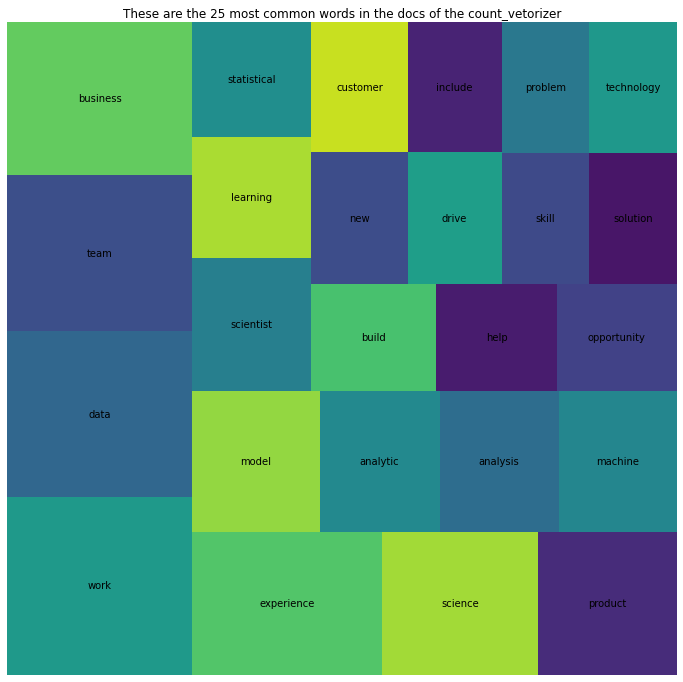

In [84]:
plt.figure(figsize=(12,12))
squarify.plot(sizes=the_count, label=the_words)
plt.axis("off")
plt.title("These are the 25 most common words in the docs of the count_vetorizer")
plt.show()

In [101]:
# Made this function that will get the info ready to run the plotting
def get_data(matrix, vectorizer,  number_to_return):
    the_list =  sort_names(matrix ,vectorizer,  number_to_return)
    the_words = [word for word , count in the_list]
    the_count = [count for word, count in the_list]
    return the_words, the_count

In [104]:
names , the_height = get_data( d_matrix,count_vect, 10)

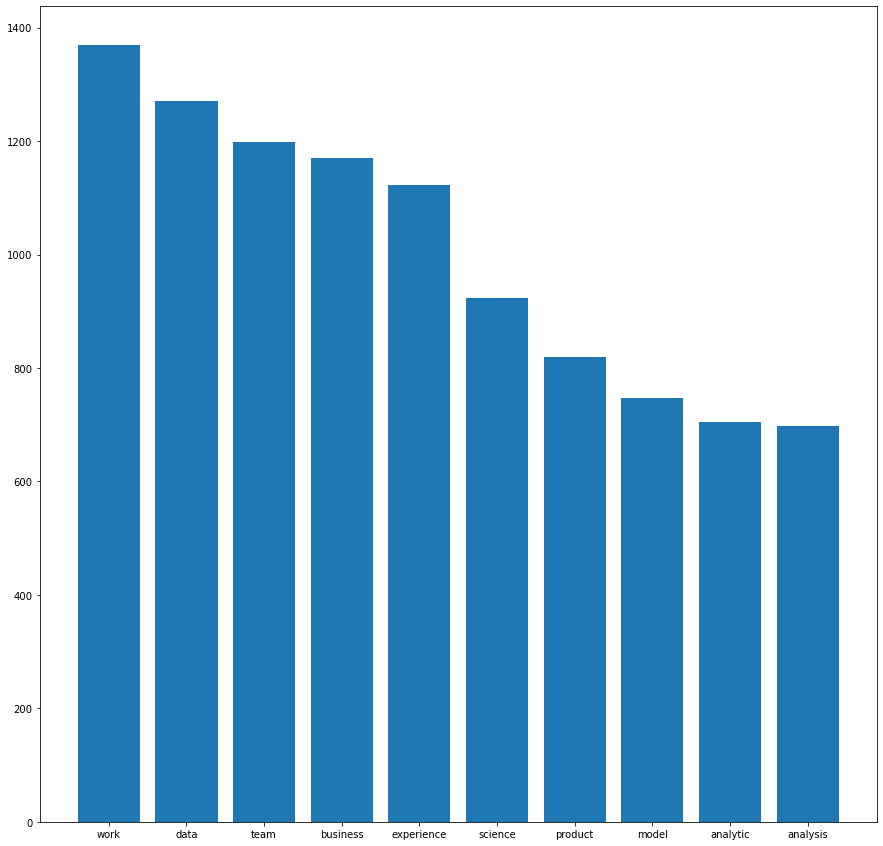

In [106]:
# visualizing the 10  most common words in matplotlib
plt.figure(figsize=(15,15))
plt.bar(x=names, height=the_height)
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [108]:
# Doing the tfifdVectorizer to the feature matrix
td = TfidfVectorizer(tokenizer=tokenize_text, max_df=.95, min_df=15)

In [109]:
# Getting the feture matrix
tfidf_matrix = td.fit_transform(word_list)

## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [ ]:
##### Your Code Here #####
raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 